## Grundwasservorhersage mittels eines Random Forests, Hessen

> author: Noura Barakat, Melvin Hildebrand
> 
> area: Hessen
> 
> date: 26.08.2024


In [267]:
## Erstmal importieren wir alle benötigten libraries

import os, sys
# import netCDF4
import pandas as pd
#import datetime
#from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import rioxarray
import xarray as xr
import glob

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [268]:
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import math
from math import sqrt

In [271]:
pwd = os.getcwd()
print(pwd)

C:\Users\nunub\OneDrive\Documents\KI_2024


### Einlesen unserer vorverarbeiteten Daten

Wir verwenden hier bereits vorverarbeitete Daten. Der Datensatz umfasst Daten von einer Grundwassermesstelle (ID: 10319, Name: Lettgenbrunn) in Hessen. Zur Vorverarbeitung haben wir die .nc-Datei auf das AOI (Gebiet von Interesse) zugeschnitten und die .nc-Dateien für bestimmte Jahre zu einer Datei zusammengeführt. Dann haben wir Klimadaten (Temperatur- und Niederschlagswerte) an bestimmten Standorten extrahiert, sie mit GW-Pegel-Daten (Grundwasserpegel-Daten) zusammengeführt und die Daten für die Messtelle als einzelne CSV-Datei gespeichert. Diese Datei ist nun die Grundlage für den Aufbau unseres Modells.

Unser nächster Schritt ist der Modellaufbau. 

In [275]:
data = pd.read_csv("./data/HYRAS_GWData_csv/HE_10319_weeklyData_HYRAS_GWData.csv", skipinitialspace=True).drop(['Unnamed: 0'], axis=1)

data.shape[0]

835

In [277]:
col2use = ['pr', 'tas', 'GWL']

In [279]:
#data = data.replace(np.inf, np.nan)
data.isnull().sum()

Date      0
pr        0
tas       0
GWL     148
dtype: int64

In [281]:
## hier werfen wir die Werte ohne Angaaben raus

data.dropna(axis=0, inplace=True)
data

Date    pr       tas     GWL
148  1992-11-02  10.2  7.900000  371.92
149  1992-11-09  35.0  6.800000  372.46
150  1992-11-16  22.8  6.914286  373.40
151  1992-11-23  21.6  8.500000  376.69
152  1992-11-30   9.5  7.385714  376.83
..          ...   ...       ...     ...
830  2005-11-28   5.9  2.714286  360.67
831  2005-12-05   7.1  3.157143  360.85
832  2005-12-12  10.2  3.200000  361.95
833  2005-12-19  12.8  2.514286  363.28
834  2005-12-26  15.3 -0.950000  364.93

[687 rows x 4 columns]

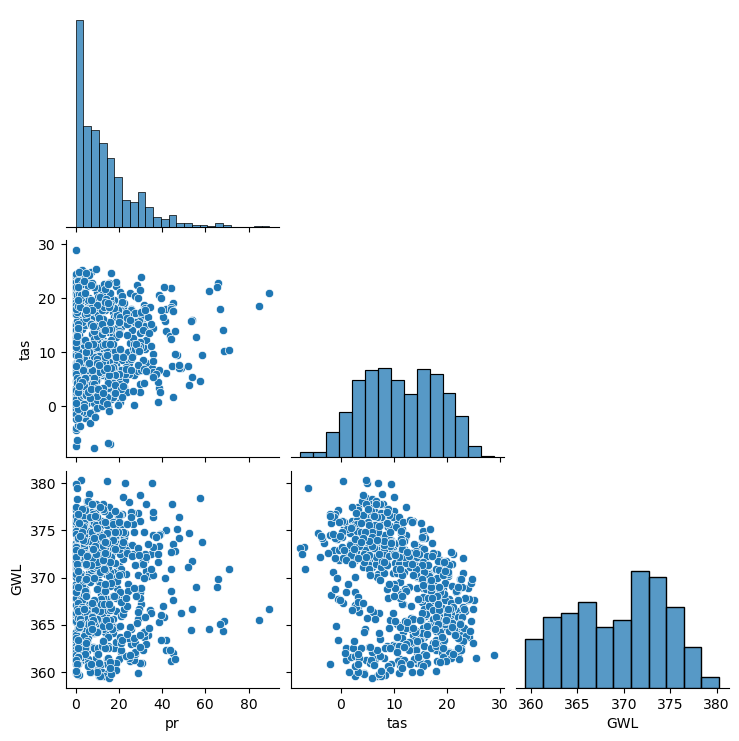

In [283]:
sns.pairplot(data[col2use], corner=True)
plt.show()

Nun integrieren wir in unseren Datensatz pro Grundwasserpegelwert die Niederschlags- (pr) und Temperaturwerte (tas) von jeweils 2, 5 und 10 Wochen im Vorhinein. Dieser Schritt ist wichtig, um die Präzision der Vorhersage zu verbessern. Der aktuelle Grundwasserpegel ist grundsätzlich auch abhängig von den Niederschlagswerten der vergangenen Wochen. Zudem kann die Temperatur der vergangenen Wochen auch ein Indikator für die Bodenfeuchte sein. 

In [286]:
data["pr_sum_rolling_2w"] = data["pr"].rolling(2).sum()

In [288]:
data["pr_sum_rolling_5w"] = data["pr"].rolling(5).sum()

In [290]:
data["pr_sum_rolling_10w"] = data["pr"].rolling(10).sum()

In [292]:
data

Date    pr       tas     GWL  pr_sum_rolling_2w  pr_sum_rolling_5w  \
148  1992-11-02  10.2  7.900000  371.92                NaN                NaN   
149  1992-11-09  35.0  6.800000  372.46               45.2                NaN   
150  1992-11-16  22.8  6.914286  373.40               57.8                NaN   
151  1992-11-23  21.6  8.500000  376.69               44.4                NaN   
152  1992-11-30   9.5  7.385714  376.83               31.1               99.1   
..          ...   ...       ...     ...                ...                ...   
830  2005-11-28   5.9  2.714286  360.67               12.6               38.6   
831  2005-12-05   7.1  3.157143  360.85               13.0               29.8   
832  2005-12-12  10.2  3.200000  361.95               17.3               39.9   
833  2005-12-19  12.8  2.514286  363.28               23.0               42.7   
834  2005-12-26  15.3 -0.950000  364.93               28.1               51.3   

     pr_sum_rolling_10w  
148                 NaN  
149                 NaN  
150                 NaN  
151                 NaN  
152                 NaN  
..                  ...  
830                91.7  
831                52.8  
832                62.0  
833                74.8  
834                84.5  

[687 rows x 7 columns]

In [294]:
data["tas_sum_rolling_2w"] = data["tas"].rolling(2).sum()

In [296]:
data["tas_sum_rolling_5w"] = data["tas"].rolling(5).sum()

In [298]:
data["tas_sum_rolling_10w"] = data["tas"].rolling(10).sum()

In [300]:
data

Date    pr       tas     GWL  pr_sum_rolling_2w  pr_sum_rolling_5w  \
148  1992-11-02  10.2  7.900000  371.92                NaN                NaN   
149  1992-11-09  35.0  6.800000  372.46               45.2                NaN   
150  1992-11-16  22.8  6.914286  373.40               57.8                NaN   
151  1992-11-23  21.6  8.500000  376.69               44.4                NaN   
152  1992-11-30   9.5  7.385714  376.83               31.1               99.1   
..          ...   ...       ...     ...                ...                ...   
830  2005-11-28   5.9  2.714286  360.67               12.6               38.6   
831  2005-12-05   7.1  3.157143  360.85               13.0               29.8   
832  2005-12-12  10.2  3.200000  361.95               17.3               39.9   
833  2005-12-19  12.8  2.514286  363.28               23.0               42.7   
834  2005-12-26  15.3 -0.950000  364.93               28.1               51.3   

     pr_sum_rolling_10w  tas_sum_rolling_2w  tas_sum_rolling_5w  \
148                 NaN                 NaN                 NaN   
149                 NaN           14.700000                 NaN   
150                 NaN           13.714286                 NaN   
151                 NaN           15.414286                 NaN   
152                 NaN           15.885714           37.500000   
..                  ...                 ...                 ...   
830                91.7            4.185714           26.485715   
831                52.8            5.871428           18.157143   
832                62.0            6.357143           13.842857   
833                74.8            5.714286           13.057143   
834                84.5            1.564286           10.635714   

     tas_sum_rolling_10w  
148                  NaN  
149                  NaN  
150                  NaN  
151                  NaN  
152                  NaN  
..                   ...  
830            91.228571  
831            80.500000  
832            69.157143  
833            59.800000  
834            47.421428  

[687 rows x 10 columns]

### Was ist ein Random Forest? 

Ein Random Forest ist ein Ensemble-Lernverfahren, das aus vielen Entscheidungsbäumen besteht, die während des Trainings
erstellt werden. Jeder Baum wird aus einem zufälligen Teil der Trainingsdaten und zufällig ausgewählten Features gebildet.
Die Vorhersagen der einzelnen Bäume werden dann zu einer Gesamtvorhersage aggregiert, was die Genauigkeit erhöht und 
Überanpassung (Overfitting) reduziert. Random Forests sind robust, flexibel und können sowohl für Klassifikations- 
als auch für Regressionsaufgaben verwendet werden.


#### Schritt 1: Datensatz in Trainings- and Testdaten aufteilen

In [304]:
data = data.set_index(pd.DatetimeIndex(data['Date']))
del data['Date']

In [306]:
data

pr       tas     GWL  pr_sum_rolling_2w  pr_sum_rolling_5w  \
Date                                                                       
1992-11-02  10.2  7.900000  371.92                NaN                NaN   
1992-11-09  35.0  6.800000  372.46               45.2                NaN   
1992-11-16  22.8  6.914286  373.40               57.8                NaN   
1992-11-23  21.6  8.500000  376.69               44.4                NaN   
1992-11-30   9.5  7.385714  376.83               31.1               99.1   
...          ...       ...     ...                ...                ...   
2005-11-28   5.9  2.714286  360.67               12.6               38.6   
2005-12-05   7.1  3.157143  360.85               13.0               29.8   
2005-12-12  10.2  3.200000  361.95               17.3               39.9   
2005-12-19  12.8  2.514286  363.28               23.0               42.7   
2005-12-26  15.3 -0.950000  364.93               28.1               51.3   

            pr_sum_rolling_10w  tas_sum_rolling_2w  tas_sum_rolling_5w  \
Date                                                                     
1992-11-02                 NaN                 NaN                 NaN   
1992-11-09                 NaN           14.700000                 NaN   
1992-11-16                 NaN           13.714286                 NaN   
1992-11-23                 NaN           15.414286                 NaN   
1992-11-30                 NaN           15.885714           37.500000   
...                        ...                 ...                 ...   
2005-11-28                91.7            4.185714           26.485715   
2005-12-05                52.8            5.871428           18.157143   
2005-12-12                62.0            6.357143           13.842857   
2005-12-19                74.8            5.714286           13.057143   
2005-12-26                84.5            1.564286           10.635714   

            tas_sum_rolling_10w  
Date                             
1992-11-02                  NaN  
1992-11-09                  NaN  
1992-11-16                  NaN  
1992-11-23                  NaN  
1992-11-30                  NaN  
...                         ...  
2005-11-28            91.228571  
2005-12-05            80.500000  
2005-12-12            69.157143  
2005-12-19            59.800000  
2005-12-26            47.421428  

[687 rows x 9 columns]

In [308]:
# Features und target trennen
X = data.drop(columns=['GWL'])
y = data['GWL']

In [310]:
# Daten in Trainings- und Testmengen aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Schritt 2: Initiales Modell trainieren

In [313]:
# Initialwert und Anzahl der Bäume für den Random Forest festlegen
seed = 196
n_estimators = 100

# RandomForest erstellen, X und y definieren und Modell trainieren
model = RandomForestRegressor(n_estimators = n_estimators, random_state = seed, max_features = 1.0,
                               min_samples_split = 2, min_samples_leaf = 1, max_depth = None)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=196)

Die Zeile model.fit(X_train, y_train) startet den Trainingsprozess eines Random Forest Regressors, nachdem der Initialwert
(Seed) und die Anzahl der Bäume festgelegt wurden. Die Parameter n_estimators und random_state legen die Anzahl der
Entscheidungsbäume und den Zufallsstartwert fest. Weitere Parameter wie max_features, min_samples_split, min_samples_leaf
und max_depth steuern die Struktur und die Komplexität der einzelnen Bäume. Während des Trainingsprozesses wird jeder Baum
auf einem zufälligen Teil der Trainingsdaten (X_train, y_train) aufgebaut, wobei eine zufällige Auswahl von Merkmalen für
die Splits verwendet wird. Durch die Aggregation der Vorhersagen aller Bäume wird ein robustes Modell erzeugt, das eine
hohe Genauigkeit bei der Vorhersage ermöglicht und gleichzeitig Überanpassung (Overfitting) reduziert.

#### Schritt 3: Evaluieren

In [342]:
# Bestimmheitsmaß und erklärte Varianz ausgeben lassen
print(f"Coefficient of determination: {model.score(X_train, y_train)}")
print(f"% Var explained: {model.score(X_train, y_train) * 100}")


Coefficient of determination: 0.9530484749262945
% Var explained: 95.30484749262945


In diesem Codeabschnitt werden 2 wichtige Leistungskennzahlen für das Modell ausgegeben: das Bestimmtheitsmaß und die erklärte Varianz.

Zusammengefasst gibt das Bestimmtheitsmaß bzw. die erklärte Varianz Auskunft darüber, wie gut ein Modell die Streuung der Daten erklärt. Ein höheres Bestimmtheitsmaß deutet auf ein besseres Modell hin, das die Daten gut beschreibt. Unser Ergebnis von ca. 0.95 suggeriert eine hohe Vorhersagegenauigkeit. 

In [345]:
y_predictions = model.predict(X_test)

In [347]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_predictions)
# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_predictions)
# R-squared scores
r2 = r2_score(y_test, y_predictions)

In [349]:
mae, mse, r2

(2.0546712560386524, 8.391051875257594, 0.6901583928593296)

In diesem Codeabschnitt werden Vorhersagen für die Testdaten erstellt. Diese Vorhersagen werden dann mit den tatsächlichen Werten verglichen und im Anschluss der durchschnittliche absolute Fehler, der durchschnittliche quadrierte Fehler und das Bestmmtheistmaß berechnet. Im Durchschnitt weichen die Vorhersagen des Modells um etwa 2,05 Einheiten (hier Meter ü. NN) von den tatsächlichen Werten ab. Ein R²-Wert von 0,69 bedeutet, dass etwa 69 % der Varianz in den tatsächlichen Werten durch das Modell erklärt werden.

In [327]:
data

pr       tas     GWL  pr_sum_rolling_2w  pr_sum_rolling_5w  \
Date                                                                       
1992-11-02  10.2  7.900000  371.92                NaN                NaN   
1992-11-09  35.0  6.800000  372.46               45.2                NaN   
1992-11-16  22.8  6.914286  373.40               57.8                NaN   
1992-11-23  21.6  8.500000  376.69               44.4                NaN   
1992-11-30   9.5  7.385714  376.83               31.1               99.1   
...          ...       ...     ...                ...                ...   
2005-11-28   5.9  2.714286  360.67               12.6               38.6   
2005-12-05   7.1  3.157143  360.85               13.0               29.8   
2005-12-12  10.2  3.200000  361.95               17.3               39.9   
2005-12-19  12.8  2.514286  363.28               23.0               42.7   
2005-12-26  15.3 -0.950000  364.93               28.1               51.3   

            pr_sum_rolling_10w  tas_sum_rolling_2w  tas_sum_rolling_5w  \
Date                                                                     
1992-11-02                 NaN                 NaN                 NaN   
1992-11-09                 NaN           14.700000                 NaN   
1992-11-16                 NaN           13.714286                 NaN   
1992-11-23                 NaN           15.414286                 NaN   
1992-11-30                 NaN           15.885714           37.500000   
...                        ...                 ...                 ...   
2005-11-28                91.7            4.185714           26.485715   
2005-12-05                52.8            5.871428           18.157143   
2005-12-12                62.0            6.357143           13.842857   
2005-12-19                74.8            5.714286           13.057143   
2005-12-26                84.5            1.564286           10.635714   

            tas_sum_rolling_10w  
Date                             
1992-11-02                  NaN  
1992-11-09                  NaN  
1992-11-16                  NaN  
1992-11-23                  NaN  
1992-11-30                  NaN  
...                         ...  
2005-11-28            91.228571  
2005-12-05            80.500000  
2005-12-12            69.157143  
2005-12-19            59.800000  
2005-12-26            47.421428  

[687 rows x 9 columns]

Allerdings könnten unsere Ergebnisse auch an der Auswahl der Trainings- und Testdaten liegen. Um den Einfluss dieser Aufteilung zu reduzieren, führen wir eine sogenannte k-fache Kreuzvalidierung (k-fold cross validation) durch. Das bedeutet, dass wir die Trainingsdaten in 10 gleich große Teile aufteilen, also $k=10$ in diesem Fall. Dann trainieren wir das Modell auf neun der 10 Teile und verwenden den 10. Teil zur Validierung des Modells wie oben beschrieben. Dieser Prozess wird 10 Mal wiederholt, wobei jedes Mal ein anderer Teil zur Validierung verwendet wird. Am Ende erhalten wir 10 RMSE-Werte, die uns einen Einblick in die Validität des oben genannten Wertes geben.

In [351]:
from sklearn.model_selection import cross_val_score
scores = - cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=1)
print(scores)
print(np.mean(scores), np.std(scores))

[ 7.99462509  7.6769795   8.86374395  7.83255243  9.20695896 10.75050609
  6.92620051  9.73670632  8.32539769 10.4834025 ]
8.779707304687633 1.1942959488195237


#### Schritt 4: Hyperparameter Tuning

Hier verwenden wir Grid Search, um die besten Hyperparameter für unser Modell zu finden. Hyperparameter sind Parameter, die nicht durch das Modelltraining selbst optimiert werden, sondern im Vorhinein festgelegt werden müssen. Sie steuern die Lernprozesse und die Architektur des Modells. Im Gegensatz zu Modellparametern, die während des Trainings durch Optimierungsalgorithmen angepasst werden, werden Hyperparameter manuell oder automatisiert (z. B. durch Grid Search) bestimmt. Grid Search durchsucht systematisch einen vordefinierten Bereich von Hyperparametern und evaluiert die Modellleistung für jede Kombination. Dies ermöglicht es, die optimalen Hyperparameter auszuwählen, die die Modellleistung maximieren und somit zu besseren Vorhersagen führen.


##### gridSearchCV

In [354]:
from sklearn.model_selection import GridSearchCV

In [355]:
rfc = RandomForestRegressor(random_state=42)


In [359]:
param_grid = { 
    'n_estimators': [50, 100, 150, 200, 250, 300],
   # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
}

In [361]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200, 250, 300]})

In [363]:
best_params = CV_rfc.best_params_

best_params

{'max_depth': 8, 'n_estimators': 150}

Der Hyperparameter max_depth bestimmt die maximale Tiefe der Entscheidungsbäume im Random Forest-Modell.
Eine Tiefe von 8 bedeutet, dass jeder Baum im Random Forest maximal 8 Ebenen tief ist. Der Hyperparameter n_estimators
gibt die Anzahl der Entscheidungsbäume im Random Forest-Modell an. In diesem Fall bedeutet n_estimators: 150, dass der
Random Forest aus 150 Entscheidungsbäumen besteht.

In [446]:
# Initialwert für den Random Forest festlegen
seed = 196


# RandomForest erstellen, X und y definieren und Modell trainieren
model = RandomForestRegressor(n_estimators = best_params["n_estimators"], 
                              random_state = seed, 
                              max_features = 1.0,
                              min_samples_split = 2, 
                              min_samples_leaf = 1, 
                              max_depth = best_params["max_depth"])
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=150, random_state=196)

In [367]:
X_train

pr        tas  pr_sum_rolling_2w  pr_sum_rolling_5w  \
Date                                                                
1998-03-02  24.1   9.985715          26.400000          42.100000   
1994-12-12   2.8   5.185714           8.900000          50.900000   
1994-05-30  12.2  15.957143          33.100000         120.300000   
1993-10-25   0.0   4.757142          20.100000          74.999999   
1997-01-06   0.0  -3.971428           8.700000          55.899998   
...          ...        ...                ...                ...   
1994-03-14  18.7   7.628571          32.300000          55.200000   
1994-11-14  16.4  10.528571          25.800000          44.500000   
1998-01-05   7.0   6.714286          23.400000          76.100000   
2001-03-05  10.6   8.071428          21.899999          49.299999   
1994-10-17   3.2   8.685714           3.200000          35.800000   

            pr_sum_rolling_10w  tas_sum_rolling_2w  tas_sum_rolling_5w  \
Date                                                                     
1998-03-02           95.700000           17.271429           30.771429   
1994-12-12           79.000000           13.685714           38.842857   
1994-05-30          196.299999           30.742857           76.385714   
1993-10-25          155.799999           11.185713           47.914285   
1997-01-06          169.199998          -11.628571          -14.571429   
...                        ...                 ...                 ...   
1994-03-14           98.300000           17.528572           28.728572   
1994-11-14          110.500000           19.814285           49.799999   
1998-01-05          145.900000           13.614286           28.142858   
2001-03-05          122.699997           11.242857           28.728571   
1994-10-17          152.700000           18.571428           56.799998   

            tas_sum_rolling_10w  
Date                             
1998-03-02            48.042858  
1994-12-12            87.999999  
1994-05-30           128.299999  
1993-10-25           123.228570  
1997-01-06            11.257143  
...                         ...  
1994-03-14            48.328572  
1994-11-14           111.528569  
1998-01-05            52.828572  
2001-03-05            44.385714  
1994-10-17           140.028566  

[549 rows x 8 columns]

#### Schritt 5: Plotten

In [371]:
stats = model.get_params()
feature_importance = model.feature_importances_
features = X.columns
var_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
var_imp_df = var_imp_df.sort_values(by = 'Importance', ascending = False).head(54)
var_imp_10 = var_imp_df.head(10)

NameError: name 'max_features' is not defined

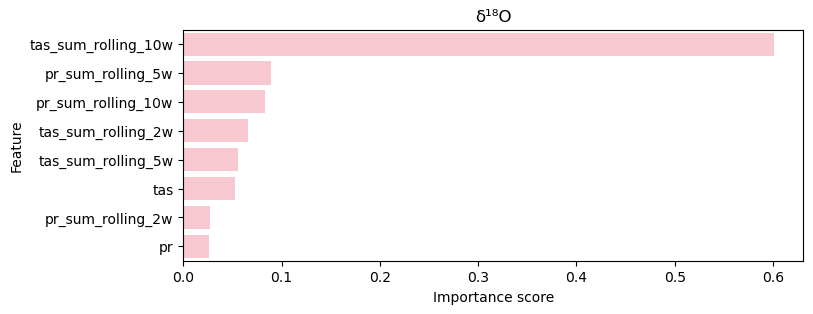

In [373]:
# Plotten der wichtigsten Variablen
plt.figure(figsize = (8, 3))
sns.barplot(x = 'Importance', y = 'Feature', data = var_imp_10, color = 'pink')
plt.title("δ¹⁸O")
plt.xlabel("Importance score")
plt.ylabel("Feature")
plt.text(0, -1.5, f"n_estimators = {n_estimators}, max_features = {max_features}\nRMSE = {rmse:.2f}, R² = {r2:.2f}", 
         fontsize = 10, ha = 'left', va = 'center')
plt.show()

Hierbei ist klar geworden, dass die Variable der Temperatur 10 Wochen im Vorhinein die Wichtigste ist.

In [387]:
data_1992_2004 = data[(data.index.year >= 1992) & (data.index.year <= 2004)]
data_2005 = data[(data.index.year >= 2005)]

In [381]:
data.index.year

Index([1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1993,
       ...
       2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005],
      dtype='int32', name='Date', length=687)

In [385]:
data_1992_2004

pr       tas     GWL  pr_sum_rolling_2w  pr_sum_rolling_5w  \
Date                                                                       
1992-11-02  10.2  7.900000  371.92                NaN                NaN   
1992-11-09  35.0  6.800000  372.46               45.2                NaN   
1992-11-16  22.8  6.914286  373.40               57.8                NaN   
1992-11-23  21.6  8.500000  376.69               44.4                NaN   
1992-11-30   9.5  7.385714  376.83               31.1               99.1   
...          ...       ...     ...                ...                ...   
2004-11-29   3.1  4.457143  374.78                7.5               41.0   
2004-12-06   0.0  0.528571  372.96                3.1               36.2   
2004-12-13  12.5  1.028571  371.89               12.5               27.7   
2004-12-20   4.6  2.157143  371.48               17.1               24.6   
2004-12-27  12.6  3.357143  373.36               17.2               32.8   

            pr_sum_rolling_10w  tas_sum_rolling_2w  tas_sum_rolling_5w  \
Date                                                                     
1992-11-02                 NaN                 NaN                 NaN   
1992-11-09                 NaN           14.700000                 NaN   
1992-11-16                 NaN           13.714286                 NaN   
1992-11-23                 NaN           15.414286                 NaN   
1992-11-30                 NaN           15.885714           37.500000   
...                        ...                 ...                 ...   
2004-11-29          120.200002            9.771429           27.157143   
2004-12-06          107.200002            4.985714           17.628572   
2004-12-13           99.500002            1.557143           15.457143   
2004-12-20           90.500002            3.185714           13.485715   
2004-12-27           98.600002            5.514286           11.528572   

            tas_sum_rolling_10w  
Date                             
1992-11-02                  NaN  
1992-11-09                  NaN  
1992-11-16                  NaN  
1992-11-23                  NaN  
1992-11-30                  NaN  
...                         ...  
2004-11-29            87.857143  
2004-12-06            74.271429  
2004-12-13            61.714286  
2004-12-20            54.757144  
2004-12-27            45.842858  

[635 rows x 9 columns]

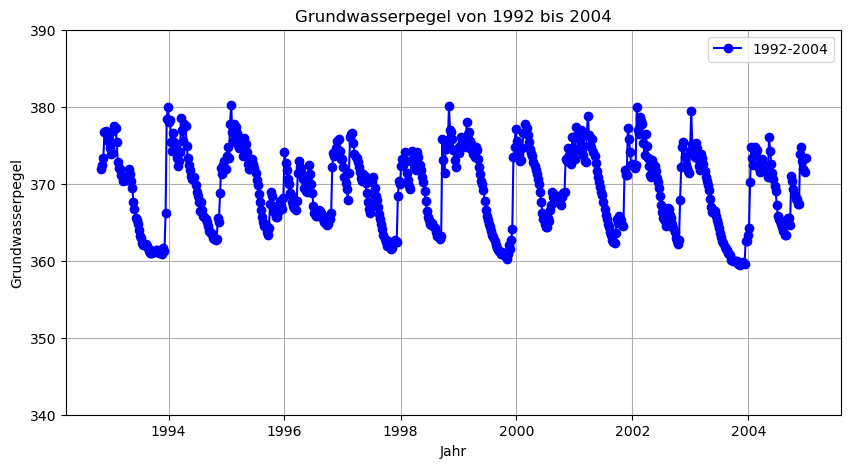

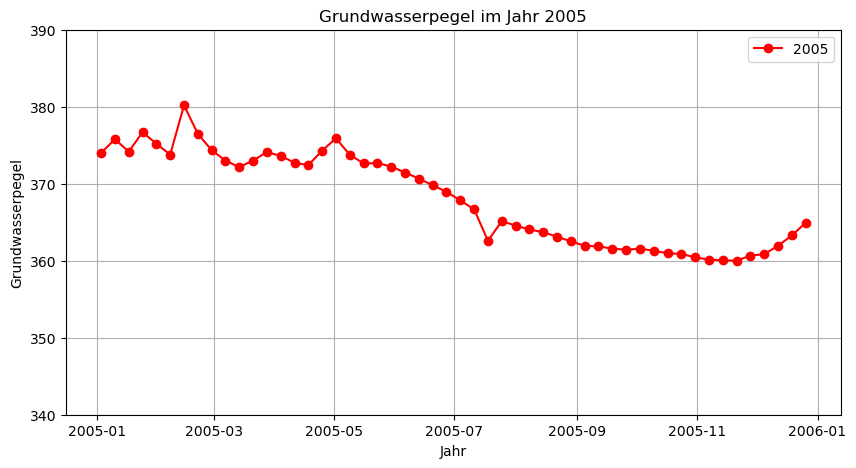

In [421]:
# Daten zwischen 1992 und 2004 plotten

plt.figure(figsize=(10, 5))
plt.plot(data_1992_2004.index, data_1992_2004['GWL'], marker='o', linestyle='-', color='b', label='1992-2004')
plt.xlabel('Jahr')
plt.ylabel('Grundwasserpegel')
plt.title('Grundwasserpegel von 1992 bis 2004')
plt.legend()
plt.grid(True)
plt.ylim(340, 390) 
plt.show()

# Daten von 2005 plotten

plt.figure(figsize=(10, 5))
plt.plot(data_2005.index, data_2005['GWL'], marker='o', linestyle='-', color='r', label='2005')
plt.xlabel('Jahr')
plt.ylabel('Grundwasserpegel')
plt.title('Grundwasserpegel im Jahr 2005')
plt.legend()
plt.grid(True)
plt.ylim(340, 390)  
plt.show()

In [397]:
X_val, y_val=data_2005.drop(columns=['GWL']), data_2005['GWL']

In [405]:
y_predictions_2005 = model.predict(X_val) 

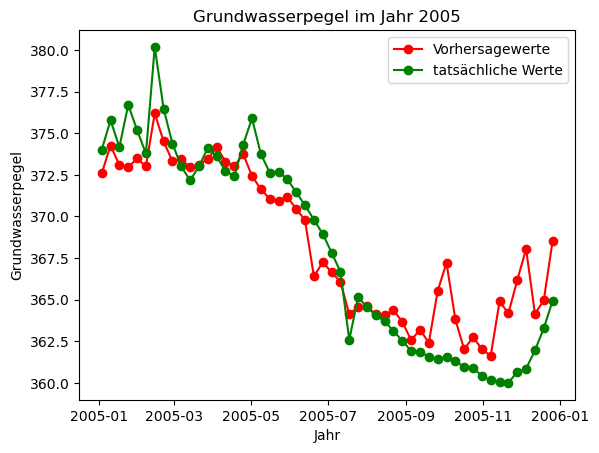

In [458]:
# Die Vorhersagewerte und die tatsächlichen Werte aus 2005 gleichzeitig plotte, um Modelleistung zu sehen. 
plt.plot(X_val.index, y_predictions_2005, marker='o', linestyle='-', color = 'red', label = 'Vorhersagewerte')
plt.plot(X_val.index, y_val, marker='o', linestyle='-', color = 'green', label = 'tatsächliche Werte')
plt.xlabel('Jahr')
plt.ylabel('Grundwasserpegel')
plt.title('Grundwasserpegel im Jahr 2005')
plt.legend()
plt.show()

Hierbei stellt der rote Graph die vom Modell vorhergesagten Were an, wobei der grüne Graph die tatsächlichen Daten von 2005 darstellt. Wir sehen, dass die Diskrepanzen zwischen den 2 Graphen relativ klein sind.

### Diskussion

Zusammenfassend haben wir hier ein Random-Forest-Modell entwickelt, um die Grundwasserstände an der Messstelle Lettgenbrunn in Hessen vorherzusagen. Dafür wurden die Grundwasserdaten der Messstelle, sowie die Temperatur- und Niederschlagsdaten für den Zeitraum von 1992 bis 2005 gesammelt und in das Modell eingespeist. Die Entscheidung, die Vorhersage auf eine einzelne Messstelle zu beschränken, wurde getroffen, um Overfitting zu vermeiden. Anfangs hatten wir versucht, die Daten mehrerer Messstellen zu aggregieren, jedoch führte dies zu einer geringeren Modellleistung. Dies lag wahrscheinlich an der hohen Heterogenität der Daten, insbesondere der Niederschlags- und Temperaturwerte, die stark zwischen den verschiedenen Messstellen variierten.

Ein wesentlicher Schritt zur Verbesserung der Modellgenauigkeit war die Erweiterung der Features um historische Daten. Neben den aktuellen Temperatur- und Niederschlagswerten wurden auch die Werte von 2, 5 und 10 Wochen zuvor einbezogen. Diese Erweiterung der Features hat sich als vorteilhaft erwiesen, da Temperatur- und Niederschlagswerte wichtige Indikatoren für die Bodenfeuchte sind und historische Werte einen bedeutenden Einfluss auf den aktuellen Grundwasserstand haben. Die Integration dieser zusätzlichen Datenpunkte hat die Vorhersagegenauigkeit deutlich verbessert.

Das Modell erzielte bei den Trainingswerten ein Bestimmtheitsmaß (R²) bzw. eine erklärte Varianz von ca. 95%, was auf eine gute Modellleistung hinweist. Bei den Testdaten erreichte das Modell ein Bestimmheitsmaß von ca. 69%. Zur Validierung des Modells wurden die vorhergesagten Grundwasserstände für das Jahr 2005 mit den tatsächlichen Werten verglichen. Die simultane Darstellung beider Datensätze in einem Plot zeigte, dass die vorhergesagten Werte den tatsächlichen Werten ziemlich nahe kamen. 

Trotzdem beobachten wir, dass die Vorhersage fehlerhaft ist. Besonders im Umgang mit extremen Werten, scheint das Modell Fehler zu machen. Ein möglicher Grund hierfür könnte die Komplexität von Grundwasserdaten generell und die limitierte Datenverfügbarkeit sein. Grundwasserstände werden von zahlreichen Faktoren beeinflusst, die in komplexen, nichtlinearen Beziehungen zueinander stehen. Einflussfaktoren wie die Bodenbeschaffenheit, anthropogene Einflüsse, die Landnutzung und die Vegetation wurden bei unserem Modell außer Acht gelassen. Die Intergration der genannten Einflussfaktoren in den Datensatz hätte vermutlich ein genaueres Vorhersagergebnis erzielt. Ferner neigen Random Forest-Modelle dazu, extremere Werte zu glätten, da sie auf dem Durchschnitt vieler Entscheidungsbäume basieren und extreme Ausprägungen in den Entscheidungsbäumen in den Mittelwert miteinfließen. Dies kann dazu führen, dass Extremwerte flacher vorausgesagt werden, als sie tatsächlich sind, wie das in unserem Modell bis ca. August 2005 der Fall ist. Unser Modell ist etwas überangepasst (overfittet), was durch die Diskrepanz zwischen den erklärten Varianzen der Trainings- und Testdaten gezeigt wird. Dies spiegelt sich in der teilweise Ungenauigkeit unserer Vorhersage wider. Außerdem sagt das Modell die Fluktuationen zum Teil extremer voraus, als sie eigentlich sind, z.B. zwischen September und November 2005. Dies könnte daran liegen, dass in den Trainingsdaten die Fluktuationen zum Ende des Jahres tendenziell extremer waren, also Extremwerte überrepräsentiert waren und das Modell diese Extremwerte in der Vorhersage überbetont. 

Insgesamt zeigt die Modellleistung jedoch, dass der Random Forest eine leistungsfähige Methode zur Vorhersage von Grundwasserständen ist, insbesondere wenn relevante historische Daten einbezogen werden. Weitere Verfeinerungen des Modells und eine erweiterte Datengrundlage um weitere Eiflussfaktoren für Gundwasserstände könnten die Vorhersagegenauigkeit weiter verbessern. 